# CM2604 Project

## End-to-End Customer churn prediction project

### Data

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

### Importing all the required modules and packages

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

### EDA (Exploratory Data Analysis)

In [72]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [73]:
#Getting the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [74]:
#Checking if there are null values and converting the total charges into a numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

<Axes: xlabel='Churn'>

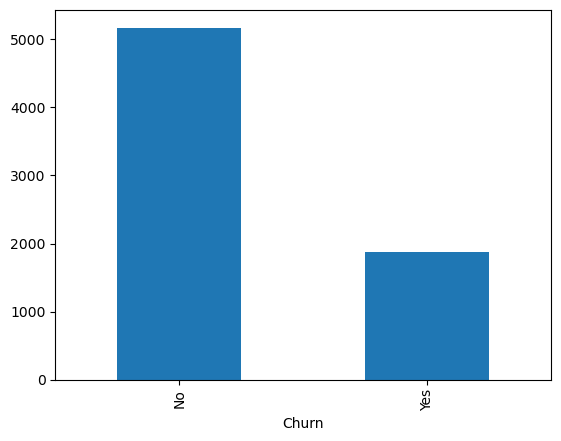

In [75]:
#Checking for class imbalances 
df.Churn.value_counts().plot.bar()

In [76]:
#Checking how the numeric datatypes vary with the target varible 

numeric_dtypes = df.select_dtypes(include='number')

In [77]:
# Drop the Customer ID column
df.drop("customerID", axis=1, inplace=True)  # Add axis=1 to drop column

# Drop rows with null TotalCharges
df.dropna(subset=["TotalCharges"], inplace=True)

# Identify categorical and binary columns
cat_col = [col for col in df.select_dtypes(include='object') if df[col].nunique() > 2]
bin_enc_col = [col for col in df.select_dtypes(include='object') if df[col].nunique() == 2]

# Set up encoders
hot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()
transformer = ColumnTransformer([
    ('one_hot', hot_encoder, cat_col),
    ('ordinal', ordinal_encoder, bin_enc_col)
], remainder='passthrough')

# Apply the transformation
transformed_df = transformer.fit_transform(df)

# Create DataFrame with proper column names 
df_encoded = pd.DataFrame(
    transformed_df,
    columns=transformer.get_feature_names_out(),
    index=df.index
)

# Convert to numeric if needed
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

#Clean the column names 
df_encoded.columns = [name.split('__')[-1] for name in df_encoded.columns]

print(f"Original shape: {df.shape}")
print(f"Encoded shape: {df_encoded.shape}")
df_encoded.head().T

Original shape: (7032, 20)
Encoded shape: (7032, 41)


,0,1,2,3,4
MultipleLines_No,0.00,1.00,1.00,0.00,1.00
MultipleLines_No phone service,1.00,0.00,0.00,1.00,0.00
MultipleLines_Yes,0.00,0.00,0.00,0.00,0.00
InternetService_DSL,1.00,1.00,1.00,1.00,0.00
InternetService_Fiber optic,0.00,0.00,0.00,0.00,1.00
InternetService_No,0.00,0.00,0.00,0.00,0.00
OnlineSecurity_No,1.00,0.00,0.00,0.00,1.00
OnlineSecurity_No internet service,0.00,0.00,0.00,0.00,0.00
OnlineSecurity_Yes,0.00,1.00,1.00,1.00,0.00
OnlineBackup_No,0.00,1.00,0.00,1.00,1.00
